In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf



In [2]:
import os
img_path = './images/3333.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
img_bg_path = './bg.jpg'
img_bg = cv2.imread(img_bg_path)
img_cat_path = './images/cat.jpg'
img_cat = cv2.imread(img_cat_path)
print (img_orig.shape)

(1067, 800, 3)


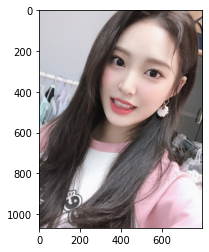

In [3]:
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

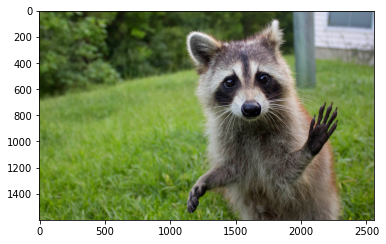

In [4]:
plt.imshow(cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB))
plt.show()

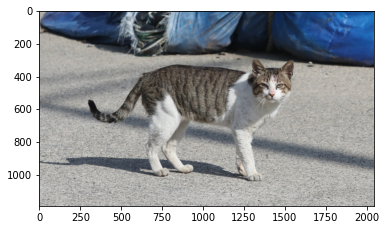

In [5]:
plt.imshow(cv2.cvtColor(img_cat, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [7]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [8]:
img_resized, seg_map = MODEL.run(img_orig)
img_resized_cat, cat_seg_map = MODEL.run(img_cat)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1067, 800, 3) (513, 384, 3) 15


In [9]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

(513, 384)


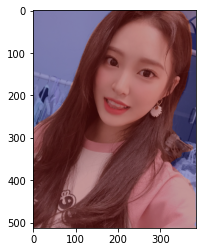

In [10]:
img_show = img_resized.copy()
print(seg_map.shape)
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

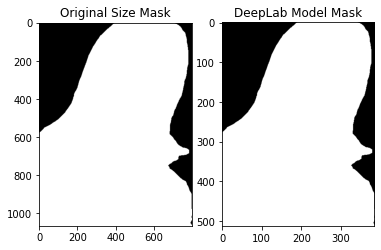

In [11]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

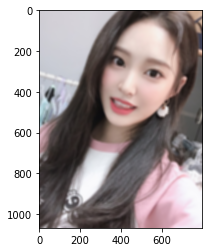

In [12]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

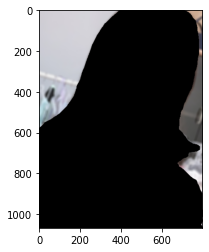

In [13]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

(513, 384)


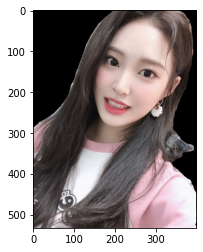

In [14]:
print(img_mask.shape)
# img_ori_resize = cv2.resize(img_orig, (img_mask.shape[1],img_mask.shape[0]), interpolation=cv2.INTER_LINEAR)
img_object = np.where(img_mask_color==255, img_orig, 0)

img_object_resize = cv2.resize(img_object, (int(img_object.shape[1]/2), int(img_object.shape[0]/2)), interpolation=cv2.INTER_LINEAR)

plt.imshow(cv2.cvtColor(img_object_resize, cv2.COLOR_BGR2RGB))
plt.show()

## 배경과 똑같이 입힐 수 있지만 배경 사진과의 조화를 위해 좌하단으로 이미지를 옮겨서 합성함.

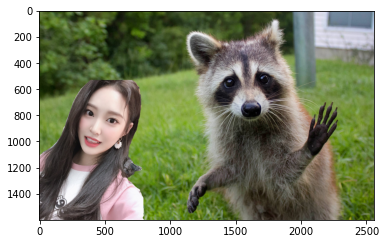

In [15]:
h,w,_ = img_object.shape
### 좌 하단 구석으로 밀기 ###
roi = img_bg[-h:,:w,:]
img_roi_concat = np.where(img_object!=0, img_object, roi)

img_bg[-h:,:w,:] = img_roi_concat
cv2.imwrite("./concat_bg.jpg",img_bg)
plt.imshow(cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB))
plt.show()


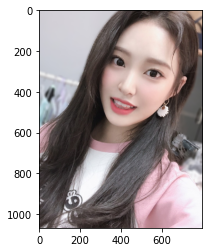

In [16]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()


In [17]:
cv2.imwrite("1111_b.jpg",img_concat)

True

(298, 513)


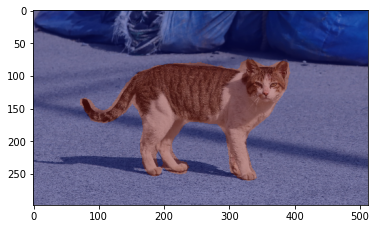

In [18]:
img_show = img_resized_cat.copy()
print(cat_seg_map.shape)
seg_map = np.where(cat_seg_map == 8, 8, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/cat_seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

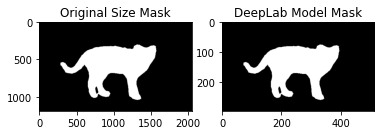

In [19]:
img_mask_up = cv2.resize(img_mask, img_cat.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

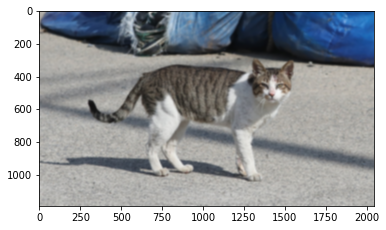

In [20]:
img_orig_blur = cv2.blur(img_cat, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

(1191, 2047, 3)


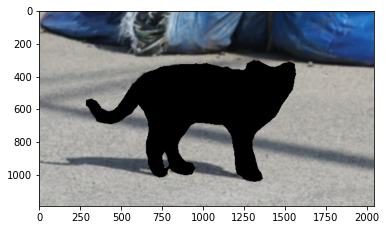

In [21]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
print(img_mask_color.shape)
img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

(298, 513)


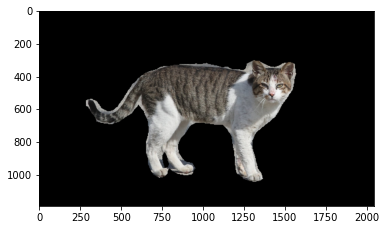

In [22]:
print(img_mask.shape)
# img_ori_resize = cv2.resize(img_orig, (img_mask.shape[1],img_mask.shape[0]), interpolation=cv2.INTER_LINEAR)
img_object = np.where(img_mask_color==255, img_cat, 0)

plt.imshow(cv2.cvtColor(img_object, cv2.COLOR_BGR2RGB))
plt.show()

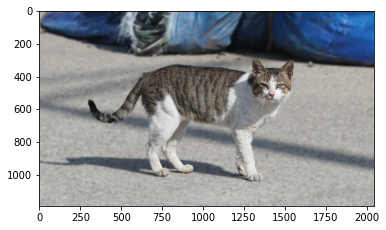

True

In [23]:
img_concat = np.where(img_mask_color==255, img_cat, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

cv2.imwrite("cat_b.jpg",img_concat)

# 문제점
## 경계선에서 차이가 많이 난다.
  - segmentation의 정확도 문제 때문에 배경과 객체의 영역의 차이가 발생하여 배경이지만 객체에 포함된 부분은 블러가 되지 않는다.


![nn](./cat1.png)

![nn](./cat1_zoom.png)

## 객체 내부에서 빈공간이 생기는 문제
  - 객체 내부는 당연히 영역이지만 segmentation을 하면 빈공간이 생길 수 있다.

- 나의 케이스에서는 문제가 발생하지는 않았지만 객체 내부에서 일부 영역은 빈 공간으로 나올 수 있다.
  - 이런 경우에는 내부 구멍을 메우기 위한 opencv 알고리즘이 있다.
  - morphology를 사용할면 작은 구멍은 메울 수 있다.

![nn](./mor_ex.png)

- 모폴로지 연산을 통해 내부의 작은 구멍을 메울 수 있을 것으로 생각 된다.

## 다른 물체임에도 영역에 포함된 경우 
- 아래의 사진을 보면 머리카락 뒷부분의 옷걸이 부분이 같이 포함되어 제대로 블러가 되지 않았다.

![nn](./zoa.png)

![nn](./zoa_zoom.png)

# Depth map를 활용한 해결방법
- Depth map을 활용하여 다른 물체와 좀더 정확하게 분리 할 수 있을것으로 생각 된다.
- 우선 깊이를 알기 위해서는 다른 각도에서 찍은 2개의 사진이나 연속된 사진이 필요하다.
  - Struct2depth은 연속된 sequence 이미지를 필요로한다.
  - sequence 이미지를 활용하고 2개의 Deeplearning network를 통과 시킨다.
  - 우선 Deeplab을 통과하면 각각의 이미지의 mask가 나오며 이 mask는 AND연산을 통해 재 설정한다.
    - AND는 둘다 True일때만 True이기 때문에 3 이미지 에서 모두 찾은 영역만으로 바뀔 것이다.
  - Struct2Depth는 3장의 데이터를 통해 한장의 Depth map image를 출력할것이다.
  - 3장을 통해 얻은 mask와 depth map을 다시 AND연산을 해서 최종적인 영역을 얻는다.  
  
참고 :  밑의 이미지의 struct2depth의 출력은 실제 출력을 활용한 것이 아니라 임의로 deeplab의 출력에 색을 입힌것임.

![nn](./sol.png)